<a href="https://colab.research.google.com/github/dpl5435/GWOSC-Project/blob/main/Challenge_3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:

! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install -q bilby
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf


# -- for gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")
gwpy_strain_L1 = TimeSeries.read('challenge3.gwf', channel="L1:CHALLENGE3")


# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')
pycbc_strain_L1 = frame.read_frame('challenge3.gwf', 'L1:CHALLENGE3')
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')
pycbc_strain_L1 = frame.read_frame('challenge3.gwf', 'L1:CHALLENGE3')

--2025-06-01 17:26:46--  https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256814830 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  27.0MB/s    in 9.5s    

2025-06-01 17:26:56 (25.7 MB/s) - ‘challenge3.gwf’ saved [256814830/256814830]



In [3]:
import bilby

sampling_rate = 2048  # needs to be high enough for the signals found in steps above
duration = 8  # needs to be long enough for the signals found in steps above
start_time = 100  # needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1', 'L1']:
    ifo = bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf', sampling_rate, duration, start_time=start_time, channel=f'{ifo_name}:CHALLENGE3')
    interferometers.append(ifo)


17:28 bilby INFO    : Reading data from frame file challenge3.gwf
17:28 bilby INFO    : Successfully loaded H1:CHALLENGE3.
17:28 bilby INFO    : Reading data from frame file challenge3.gwf
17:28 bilby INFO    : Successfully loaded L1:CHALLENGE3.


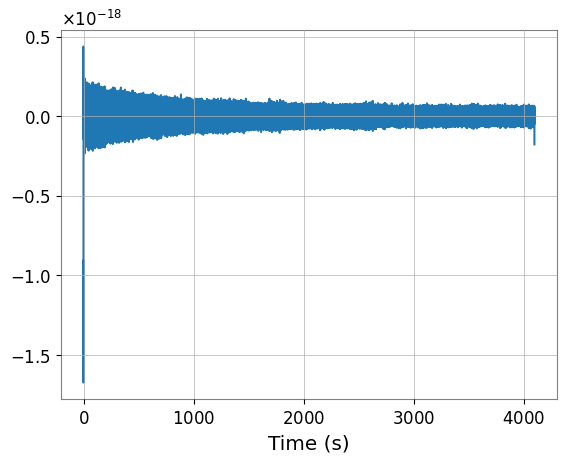

In [4]:
import matplotlib.pyplot as plt
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass

strain = pycbc_strain


# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.show()

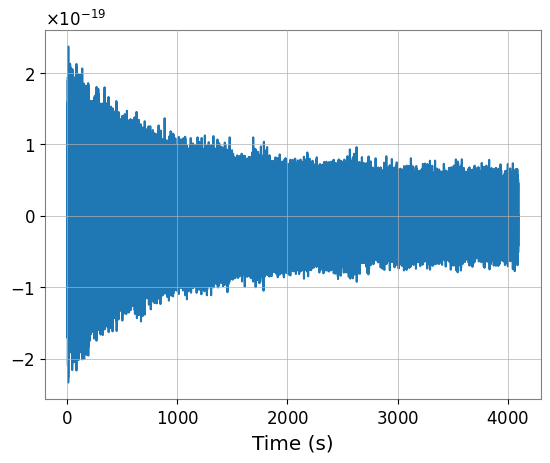

In [5]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')
plt.show()

In [6]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [7]:
from pycbc.waveform import get_td_waveform

m=10 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

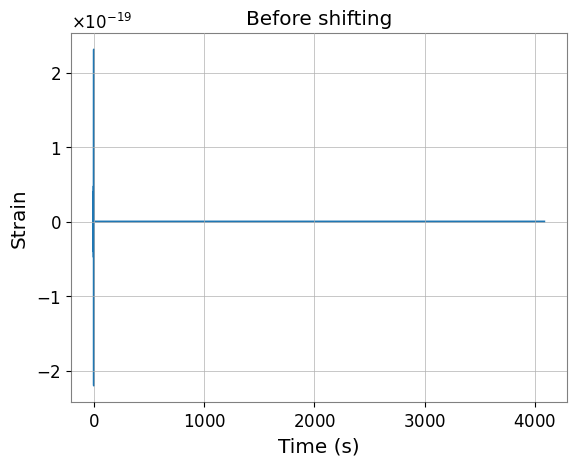

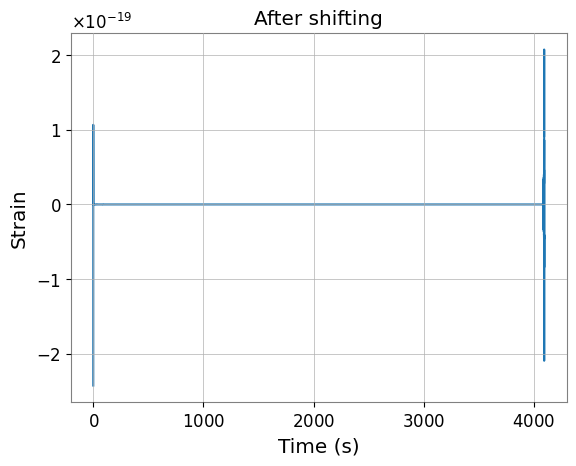

In [8]:
# Let's plot the signal before and after shifting

plt.figure()
plt.title('Before shifting')
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

plt.figure()
plt.title('After shifting')
plt.plot(template.sample_times, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

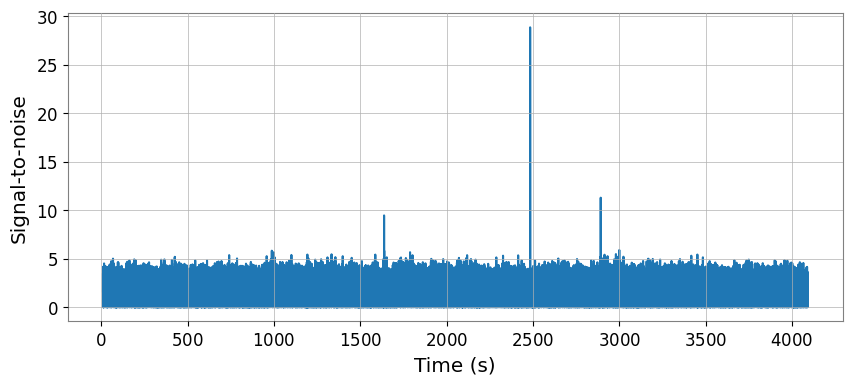

We found a signal at 2483.96728515625s with SNR 28.876520034076396


In [9]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for
# so short a template). A longer signal such as from a BNS, would
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion corresponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be
# anything, we choose to maximize over the phase of the signal.
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

In [10]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

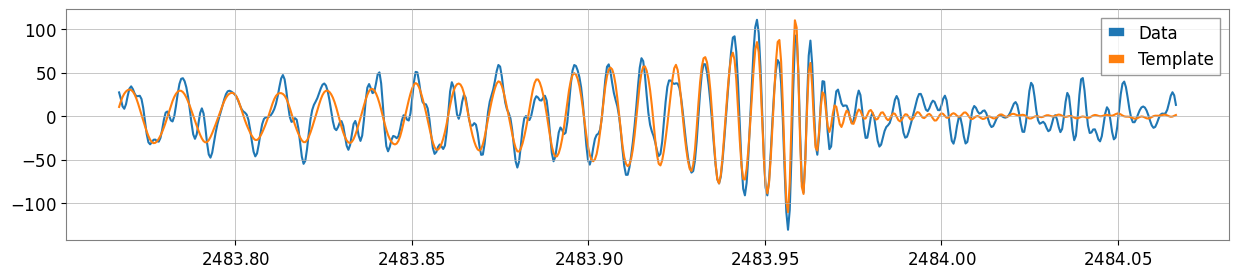

In [11]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-.2, time+.1)
white_template = white_template.time_slice(time-.2,time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data, label="Data")
plt.plot(white_template.sample_times, white_template, label="Template")
plt.legend()
plt.show()

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(time - 2,time + 1)
    plt.show()